In [1]:
import pandas as pd
import docx
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
import re
import plotly.express as px

In [2]:
# Function to extract text from Word document
def extract_text_from_docx(docx_path):
    doc = docx.Document(docx_path)
    text = [para.text for para in doc.paragraphs if para.text.strip()]
    return text

In [3]:
def parse_reviews(text):
    reviews = []
    current_date = None

    for line in text:
        if 'Feedback report' in line:
            # Extract the date from the line
            date_match = re.search(r'\((.*?)\)', line)
            if date_match:
                current_date = date_match.group(1).strip()
        elif '(' in line and ')' in line:
            try:
                # Extract rating
                rating_match = re.search(r'\((\d) stars?\)', line)
                if rating_match:
                    rating = int(rating_match.group(1))

                    # Extract review text and merchant
                    review_merchant_match = re.search(r'^(.*?)\((\d) stars?\)', line)
                    if review_merchant_match:
                        review_text = review_merchant_match.group(1).strip()
                        merchant = line.replace(review_text, '').replace(f'({rating} stars)', '').strip()

                        reviews.append({'merchant': merchant, 'review': review_text, 'rating': rating, 'date': current_date})
                    else:
                        print(f"Skipping line: {line}. Unable to extract review text and merchant.")
            except Exception as e:
                print(f"Skipping line due to error: {e}, Line: {line}")
        else:
            print(f"Skipping line: {line}")  # Add this line for debugging
    return reviews


##### Using TextBlob

In [4]:
# Function to perform sentiment analysis
def sentiment_analysis(review):
    return TextBlob(review).sentiment.polarity

##### Using Vader

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment_analysis_vader(review):
    try:
        sia = SentimentIntensityAnalyzer()
        scores = sia.polarity_scores(review)
        return scores['compound']
    except Exception as e:
        return {"error": str(e)}

# Example usage
review = "This app is a joke, they never let you apply your reward points to get a free item and then they take your points away just like that they disappeared without placing any order "
print(sentiment_analysis_vader(review))

0.8689


##### Using BERT

In [39]:
from transformers import pipeline

def sentiment_analysis_bert(review):
    try:
        # Load the sentiment-analysis pipeline with a specified model
        nlp = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
        result = nlp(review)[0]
        
        label = result['label']
        score = result['score']
        
        # Interpret the score as sentiment score
        sentiment_score = score if label == "POSITIVE" else -score
        
        return sentiment_score
    except Exception as e:
        return {"error": str(e)}

# Example usage
review = "The app, while great when it works, repeatedly crashes or loses connection, making it difficult to order."
print(sentiment_analysis_bert(review))

-0.9994795918464661


In [11]:
# Create a DataFrame
df = pd.DataFrame(reviews)

In [20]:
df.head(15)

merchant                                             review  \
0                        The app is very clean and easy to navigate. Ea...   
1          Tops Bar-B-Q                  Very easy to customize your order   
2      Jules Thin Crust                 Awesome pizza and easy app to use!   
3           Tonyburgers                               Ready, nice rewards.   
4           Tonyburgers  Easy to use app. Amazing Food! Highly recommen...   
5      TNT Coney Island  The app is incredibly easy to use and fast as ...   
6   Iron + Grain Coffee       Convenient but they charge 4% to use a card.   
7        Juice n’ Bowls                         Why do they ask for a tip?   
8          Zestia Greek  Easy app to use. Wish the 19 mile location wou...   
9     The Market Basket  The app worked well for my sandwich order. It'...   
10        Crema Gourmet  Could be better. Dollar amounts don’t update a...   
11        Crema Gourmet  This app is a joke, they never let you apply y...   
12             Lovebird  Of course I love Lovebird’s food. But this rev...   
13             Hometown  I really appreciate how super organized and ea...   
14              Taimoca                      Great app and great smoothies   

    rating  date  
0        5  None  
1        5  None  
2        5  None  
3        5  None  
4        5  None  
5        5  None  
6        3  None  
7        4  None  
8        5  None  
9        4  None  
10       3  None  
11       1  None  
12       5  None  
13       5  None  
14       5  None

In [13]:
# File path where the CSV will be saved
file_path = '/Users/prana/Documents/MDS/seentiment.csv'

# Save DataFrame as CSV
df.to_csv(file_path, index=False)

file_path

'/Users/prana/Documents/MDS/sentiment.csv'

In [5]:
df = pd.read_csv('nlp.csv')

In [6]:
# Anonymize the merchant names

# Create a dictionary to store mapping of unique merchant names to anonymized names
anonymized_mapping = {}

# Function to anonymize merchant names
def anonymize_name(name):
    if name not in anonymized_mapping:
        anonymized_mapping[name] = 'Merchant {}'.format(len(anonymized_mapping) + 1)
    return anonymized_mapping[name]

df['anonymized_merchant'] = df['merchant'].apply(anonymize_name)

### 1. Initial Sentiment Analysis

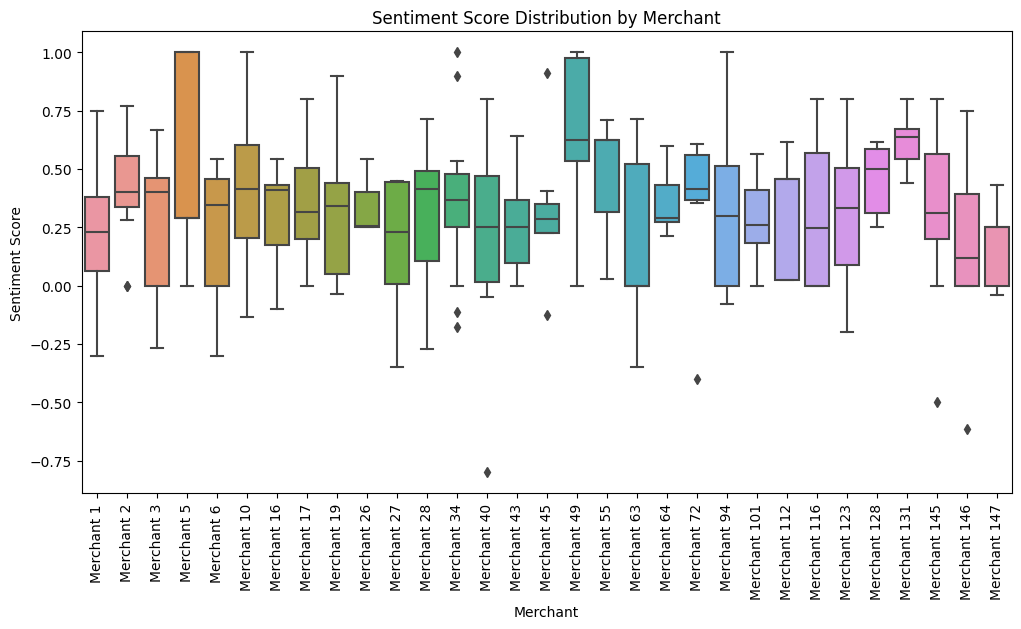

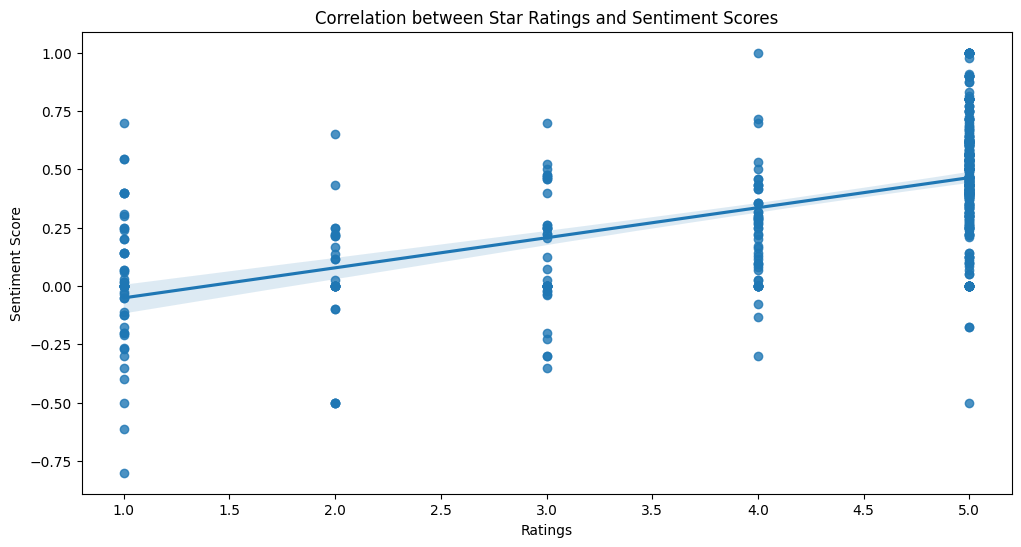

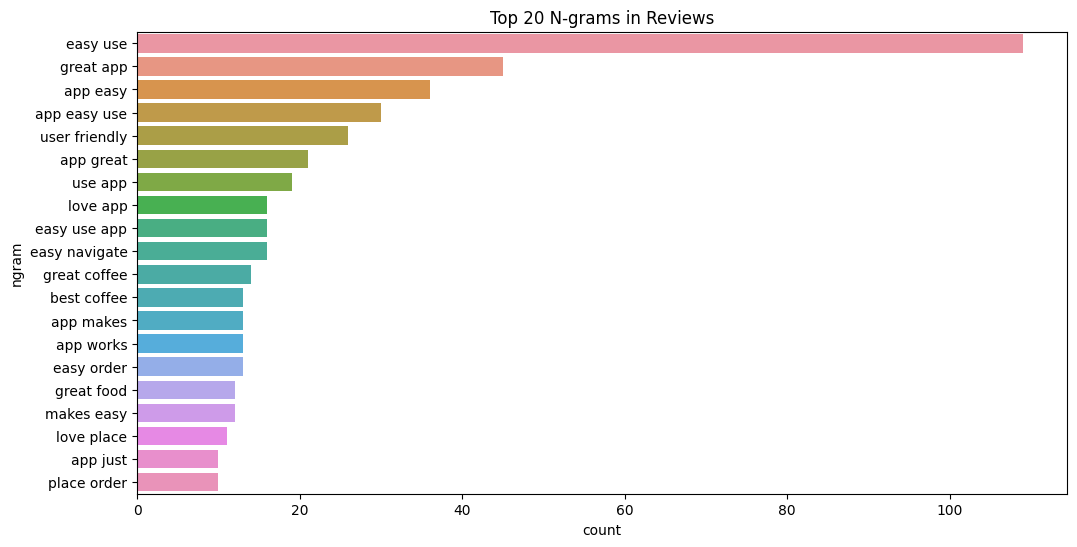

Average Ratings:
 anonymized_merchant
Merchant 1      3.944444
Merchant 10     4.666667
Merchant 101    4.363636
Merchant 112    4.200000
Merchant 116    4.000000
Merchant 123    4.625000
Merchant 128    4.333333
Merchant 131    5.000000
Merchant 145    3.666667
Merchant 146    2.750000
Merchant 147    3.600000
Merchant 16     4.250000
Merchant 17     4.812500
Merchant 19     3.250000
Merchant 2      4.454545
Merchant 26     2.600000
Merchant 27     3.333333
Merchant 28     4.142857
Merchant 3      4.000000
Merchant 34     3.875000
Merchant 40     3.454545
Merchant 43     4.857143
Merchant 45     3.875000
Merchant 49     4.800000
Merchant 5      4.200000
Merchant 55     4.285714
Merchant 6      3.545455
Merchant 63     3.000000
Merchant 64     4.272727
Merchant 72     4.333333
Merchant 94     4.228571
Name: rating, dtype: float64

Frequency of Mention:
 Merchant 94     35
Merchant 1      18
Merchant 17     16
Merchant 34     16
Merchant 3      13
Merchant 6      11
Merchant 101    11
M

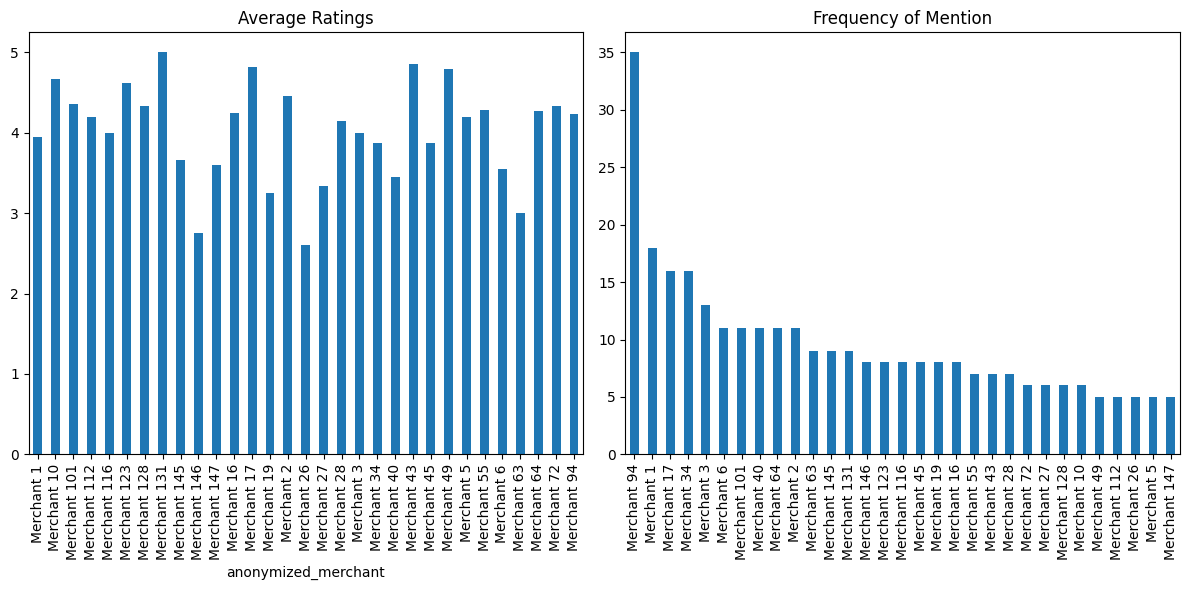

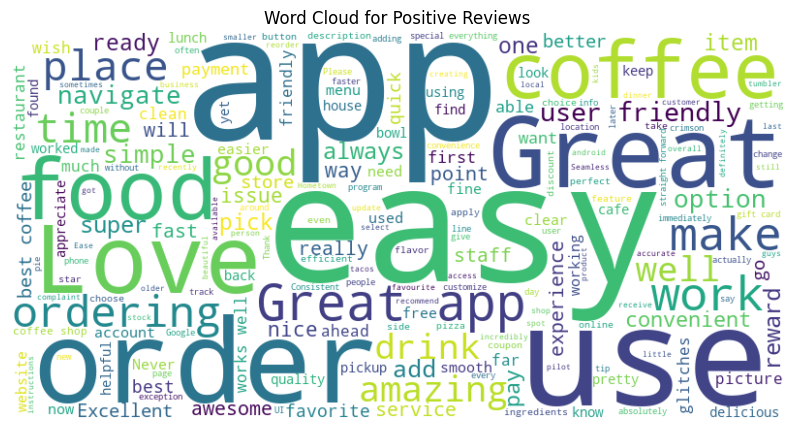

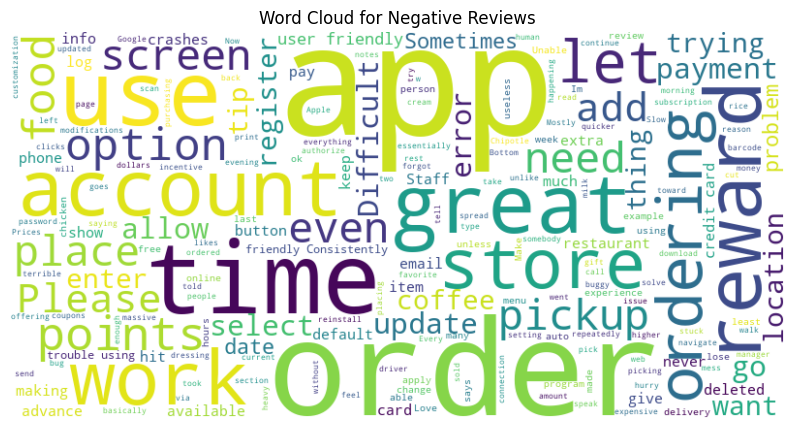

In [7]:
# Create a DataFrame
# df = pd.DataFrame(reviews)

import plotly.graph_objects as go

# Clean the review text
df['review'] = df['review'].astype(str).apply(lambda x: x.strip())

# Perform sentiment analysis
df['sentiment'] = df['review'].apply(sentiment_analysis)

# Star Rating Analysis
average_ratings = df.groupby('anonymized_merchant')['rating'].mean()

# Frequency of Mention
mention_counts = df['anonymized_merchant'].value_counts()

# Keyword Analysis (word cloud for positive reviews)
positive_reviews = ' '.join(df[df['rating'] >= 4]['review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

negative_reviews = ' '.join(df[df['rating'] <= 2]['review'])
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Comparative Analysis of Positive vs. Negative Feedback
positive_reviews_count = df[df['rating'] >= 4]['anonymized_merchant'].value_counts()
negative_reviews_count = df[df['rating'] < 4]['anonymized_merchant'].value_counts()

# Filter merchants with at least 5 reviews
review_counts = df['anonymized_merchant'].value_counts()
merchants_with_enough_reviews = review_counts[review_counts >= 5].index

filtered_df = df[df['anonymized_merchant'].isin(merchants_with_enough_reviews)]

# Sentiment Score Distribution for filtered merchants
plt.figure(figsize=(12, 6))
sns.boxplot(x='anonymized_merchant', y='sentiment', data=filtered_df)
plt.title('Sentiment Score Distribution by Merchant')
plt.xticks(rotation=90)
plt.xlabel('Merchant') 
plt.ylabel('Sentiment Score')
plt.show()

# Correlation Analysis
plt.figure(figsize=(12, 6))
sns.regplot(x='rating', y='sentiment', data=df, fit_reg=True)
plt.title('Correlation between Star Ratings and Sentiment Scores')
plt.xlabel('Ratings')
plt.ylabel('Sentiment Score')
plt.show()

# N-gram Analysis
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(df['review'])
ngrams = vectorizer.get_feature_names_out()
count_values = X.toarray().sum(axis=0)
ngrams_freq = pd.DataFrame({'ngram': ngrams, 'count': count_values})
ngrams_freq = ngrams_freq.sort_values(by='count', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='ngram', data=ngrams_freq)
plt.title('Top 20 N-grams in Reviews')
plt.show()

# Star Rating Analysis for filtered merchants
average_ratings = filtered_df.groupby('anonymized_merchant')['rating'].mean()

# Frequency of Mention for filtered merchants
mention_counts = filtered_df['anonymized_merchant'].value_counts()

# Comparative Analysis of Positive vs. Negative Feedback for filtered merchants
positive_reviews_count = filtered_df[filtered_df['rating'] >= 4]['anonymized_merchant'].value_counts()
negative_reviews_count = filtered_df[filtered_df['rating'] < 4]['anonymized_merchant'].value_counts()

# Display results
print("Average Ratings:\n", average_ratings)
print("\nFrequency of Mention:\n", mention_counts)
print("\nPositive Reviews Count:\n", positive_reviews_count)
print("\nNegative Reviews Count:\n", negative_reviews_count)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
average_ratings.plot(kind='bar', title='Average Ratings')
plt.subplot(1, 2, 2)
mention_counts.plot(kind='bar', title='Frequency of Mention')
plt.tight_layout()
plt.show()

# Display word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

### 2. Analysis of Positive and Negative Reviews

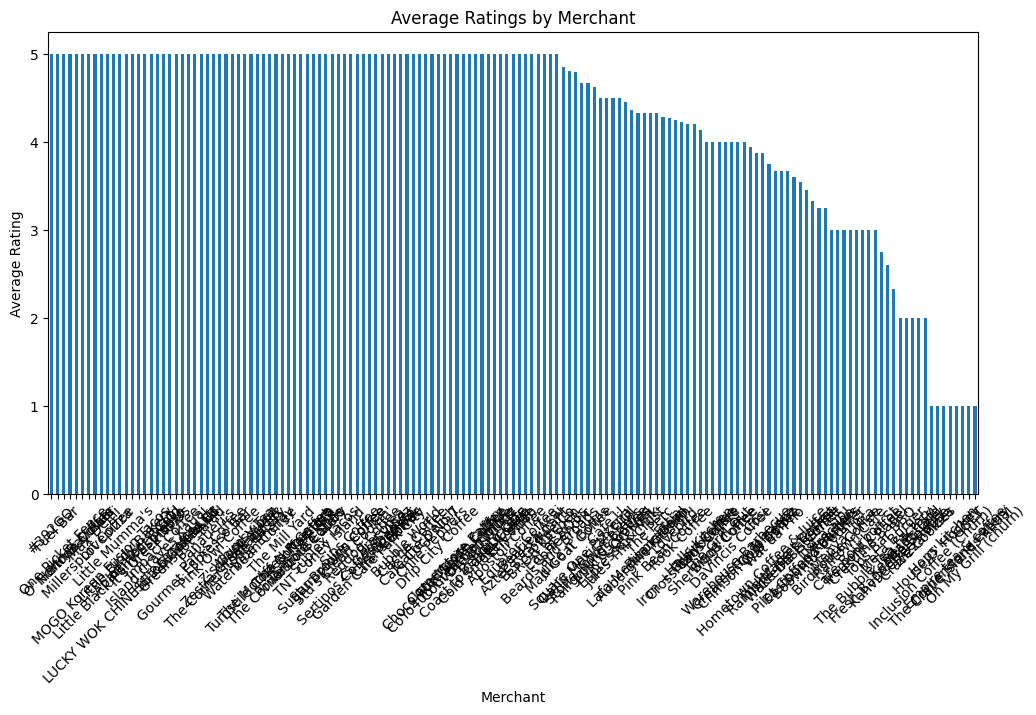

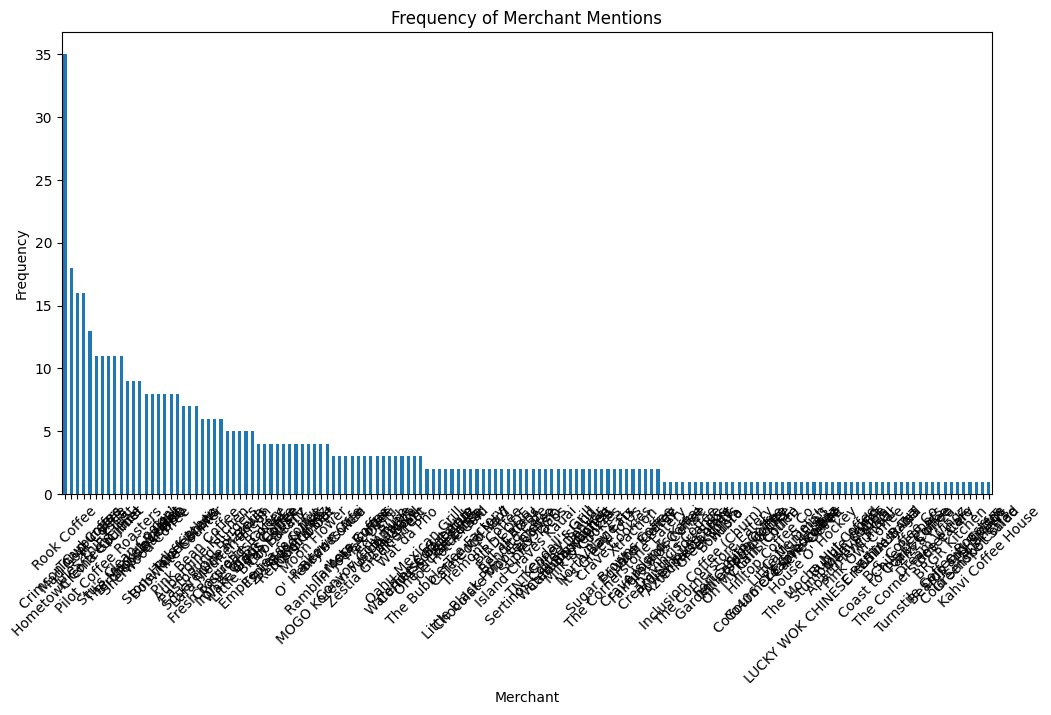

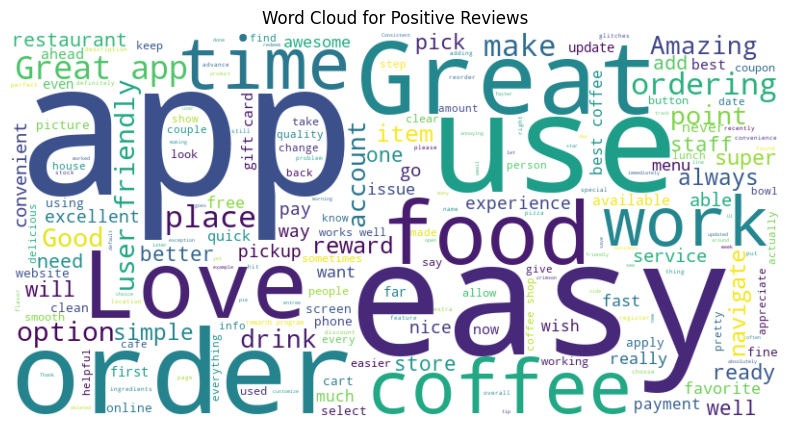

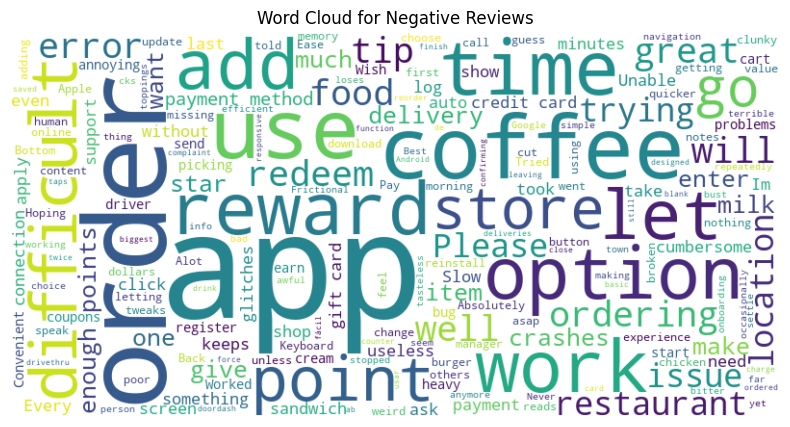

Top 10 words in positive reviews: [('the', 349), ('to', 336), ('and', 254), ('app', 172), ('is', 151), ('I', 135), ('easy', 115), ('a', 91), ('use', 83), ('it', 83)]
Top 10 words in negative reviews: [('to', 63), ('the', 59), ('and', 39), ('a', 34), ('I', 33), ('app', 30), ('it', 24), ('order', 20), ('for', 19), ('is', 19)]


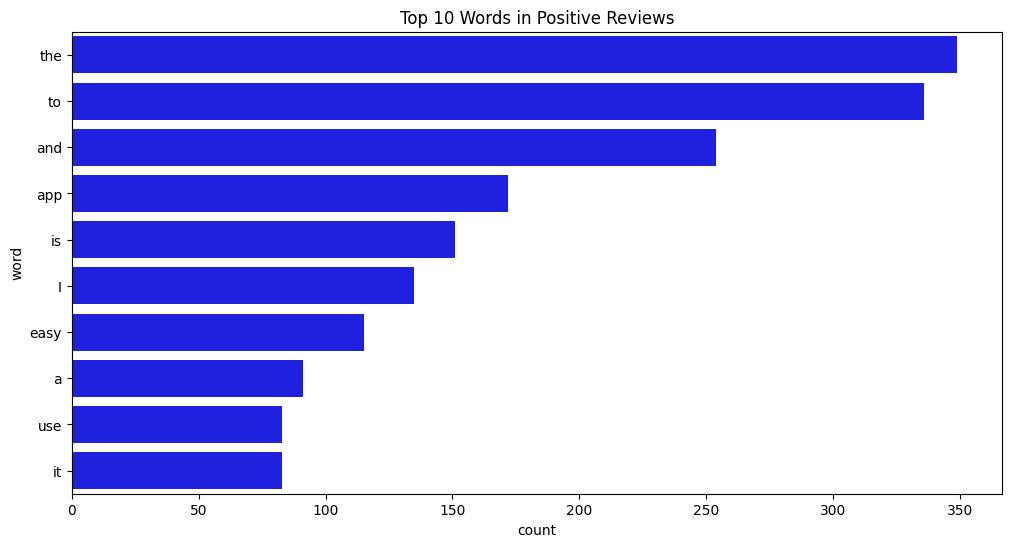

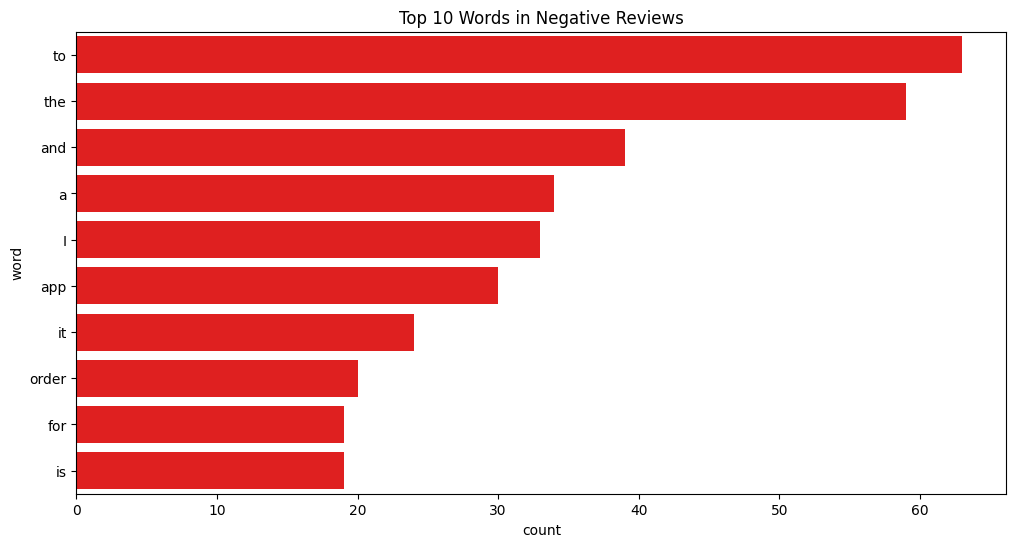

In [8]:
# Clean the review text
df['review'] = df['review'].astype(str).apply(lambda x: x.strip())

# Perform sentiment analysis
df['sentiment'] = df['review'].apply(sentiment_analysis)

# Split reviews into positive and negative
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Star Rating Analysis
average_ratings = df.groupby('merchant')['rating'].mean()

# Frequency of Mention
mention_counts = df['merchant'].value_counts()

# Visualizing Average Ratings
plt.figure(figsize=(12, 6))
average_ratings.sort_values(ascending=False).plot(kind='bar')
plt.title('Average Ratings by Merchant')
plt.xlabel('Merchant')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

# Visualizing Frequency of Mentions
plt.figure(figsize=(12, 6))
mention_counts.plot(kind='bar')
plt.title('Frequency of Merchant Mentions')
plt.xlabel('Merchant')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Word Cloud for Positive Reviews
positive_reviews = ' '.join(df[df['sentiment_category'] == 'positive']['review'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

# Word Cloud for Negative Reviews
negative_reviews = ' '.join(df[df['sentiment_category'] == 'negative']['review'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

# Detailed comparison between positive and negative reviews
positive_word_counts = Counter(positive_reviews.split())
negative_word_counts = Counter(negative_reviews.split())

# Top 10 words in positive reviews
positive_top_10 = positive_word_counts.most_common(10)
print("Top 10 words in positive reviews:", positive_top_10)

# Top 10 words in negative reviews
negative_top_10 = negative_word_counts.most_common(10)
print("Top 10 words in negative reviews:", negative_top_10)

# Visualizing top words
positive_df = pd.DataFrame(positive_top_10, columns=['word', 'count'])
negative_df = pd.DataFrame(negative_top_10, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=positive_df, color='blue')
plt.title('Top 10 Words in Positive Reviews')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=negative_df, color='red')
plt.title('Top 10 Words in Negative Reviews')
plt.show()

### 3. N-Gram Analysis

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px

# Function to get top n-grams
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Assuming df is a DataFrame containing the reviews and sentiment categories
positive_corpus = df[df['sentiment_category'] == 'positive']['review'].tolist()
negative_corpus = df[df['sentiment_category'] == 'negative']['review'].tolist()

# Get top bigrams and trigrams for positive reviews
positive_bigrams = get_top_ngrams(positive_corpus, n=10, ngram_range=(2, 2))
positive_trigrams = get_top_ngrams(positive_corpus, n=10, ngram_range=(3, 3))

# Get top bigrams and trigrams for negative reviews
negative_bigrams = get_top_ngrams(negative_corpus, n=10, ngram_range=(2, 2))
negative_trigrams = get_top_ngrams(negative_corpus, n=10, ngram_range=(3, 3))

# Display top n-grams
print("Top 10 Bigrams in Positive Reviews:", positive_bigrams)
print("Top 10 Trigrams in Positive Reviews:", positive_trigrams)
print("Top 10 Bigrams in Negative Reviews:", negative_bigrams)
print("Top 10 Trigrams in Negative Reviews:", negative_trigrams)

# Create DataFrames for bigrams and trigrams
positive_bigrams_df = pd.DataFrame(positive_bigrams, columns=['bigram', 'count'])
negative_bigrams_df = pd.DataFrame(negative_bigrams, columns=['bigram', 'count'])
positive_trigrams_df = pd.DataFrame(positive_trigrams, columns=['trigram', 'count'])
negative_trigrams_df = pd.DataFrame(negative_trigrams, columns=['trigram', 'count'])

# Generate color list
colors = px.colors.qualitative.Plotly

# Plot top bigrams for positive reviews
fig1 = px.bar(positive_bigrams_df, x='count', y='bigram', orientation='h', title='Top 10 Bigrams in Positive Reviews',
              color='bigram')
fig1.update_layout(showlegend=False)
fig1.show()

# Plot top bigrams for negative reviews
fig2 = px.bar(negative_bigrams_df, x='count', y='bigram', orientation='h', title='Top 10 Bigrams in Negative Reviews',
              color='bigram')
fig2.update_layout(showlegend=False)
fig2.show()

# Plot top trigrams for positive reviews
fig3 = px.bar(positive_trigrams_df, x='count', y='trigram', orientation='h', title='Top 10 Trigrams in Positive Reviews',
              color='trigram')
fig3.update_layout(showlegend=False)
fig3.show()

# Plot top trigrams for negative reviews
fig4 = px.bar(negative_trigrams_df, x='count', y='trigram', orientation='h', title='Top 10 Trigrams in Negative Reviews',
              color='trigram')
fig4.update_layout(showlegend=False)
fig4.show()


Top 10 Bigrams in Positive Reviews: [('easy use', 109), ('great app', 43), ('app easy', 36), ('user friendly', 25), ('use app', 19), ('app great', 19), ('love app', 16), ('easy navigate', 16), ('great coffee', 13), ('easy order', 13)]
Top 10 Trigrams in Positive Reviews: [('app easy use', 30), ('easy use app', 16), ('great app easy', 8), ('great app great', 7), ('app makes easy', 7), ('easy use convenient', 6), ('makes easy order', 6), ('love place app', 5), ('food app easy', 5), ('food great app', 5)]
Top 10 Bigrams in Negative Reviews: [('add payment', 4), ('coffee app', 3), ('redeem rewards', 3), ('gift card', 3), ('credit card', 3), ('apply rewards', 3), ('difficult use', 3), ('app order', 3), ('order food', 3), ('earn points', 2)]
Top 10 Trigrams in Negative Reviews: [('add heavy cream', 2), ('heavy cream milk', 2), ('cream milk add', 2), ('milk add coupons', 2), ('add coupons send', 2), ('coupons send work', 2), ('send work enter', 2), ('work enter use', 2), ('add payment methods

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px

# Function to get top n-grams
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Assuming df is a DataFrame containing the reviews and sentiment categories
positive_corpus = df[df['sentiment_category'] == 'positive']['review'].tolist()
negative_corpus = df[df['sentiment_category'] == 'negative']['review'].tolist()

# Get top bigrams and trigrams for positive reviews
positive_bigrams = get_top_ngrams(positive_corpus, n=10, ngram_range=(2, 2))
positive_trigrams = get_top_ngrams(positive_corpus, n=10, ngram_range=(3, 3))

# Get top bigrams and trigrams for negative reviews
negative_bigrams = get_top_ngrams(negative_corpus, n=10, ngram_range=(2, 2))
negative_trigrams = get_top_ngrams(negative_corpus, n=10, ngram_range=(3, 3))

# Display top n-grams
print("Top 10 Bigrams in Positive Reviews:", positive_bigrams)
print("Top 10 Trigrams in Positive Reviews:", positive_trigrams)
print("Top 10 Bigrams in Negative Reviews:", negative_bigrams)
print("Top 10 Trigrams in Negative Reviews:", negative_trigrams)

# Create DataFrames for bigrams and trigrams
positive_bigrams_df = pd.DataFrame(positive_bigrams, columns=['bigram', 'count']).sort_values(by='count', ascending=False)
negative_bigrams_df = pd.DataFrame(negative_bigrams, columns=['bigram', 'count']).sort_values(by='count', ascending=False)
positive_trigrams_df = pd.DataFrame(positive_trigrams, columns=['trigram', 'count']).sort_values(by='count', ascending=False)
negative_trigrams_df = pd.DataFrame(negative_trigrams, columns=['trigram', 'count']).sort_values(by='count', ascending=False)

# Plot top bigrams for positive reviews
fig1 = px.bar(positive_bigrams_df, x='count', y='bigram', orientation='h', title='Top 10 Bigrams in Positive Reviews', color_discrete_sequence=['darkgreen'])
fig1.update_layout(yaxis={'categoryorder':'total ascending'})
fig1.show()

# Plot top bigrams for negative reviews
fig2 = px.bar(negative_bigrams_df, x='count', y='bigram', orientation='h', title='Top 10 Bigrams in Negative Reviews', color_discrete_sequence=['darkred'])
fig2.update_layout(yaxis={'categoryorder':'total ascending'})
fig2.show()

# Plot top trigrams for positive reviews
fig3 = px.bar(positive_trigrams_df, x='count', y='trigram', orientation='h', title='Top 10 Trigrams in Positive Reviews')
fig3.update_layout(yaxis={'categoryorder':'total ascending'})
fig3.show()

# Plot top trigrams for negative reviews
fig4 = px.bar(negative_trigrams_df, x='count', y='trigram', orientation='h', title='Top 10 Trigrams in Negative Reviews', color_discrete_sequence=['red'])
fig4.update_layout(yaxis={'categoryorder':'total ascending'})
fig4.show()


Top 10 Bigrams in Positive Reviews: [('easy use', 109), ('great app', 43), ('app easy', 36), ('user friendly', 25), ('use app', 19), ('app great', 19), ('love app', 16), ('easy navigate', 16), ('great coffee', 13), ('easy order', 13)]
Top 10 Trigrams in Positive Reviews: [('app easy use', 30), ('easy use app', 16), ('great app easy', 8), ('great app great', 7), ('app makes easy', 7), ('easy use convenient', 6), ('makes easy order', 6), ('love place app', 5), ('food app easy', 5), ('food great app', 5)]
Top 10 Bigrams in Negative Reviews: [('add payment', 4), ('coffee app', 3), ('redeem rewards', 3), ('gift card', 3), ('credit card', 3), ('apply rewards', 3), ('difficult use', 3), ('app order', 3), ('order food', 3), ('earn points', 2)]
Top 10 Trigrams in Negative Reviews: [('add heavy cream', 2), ('heavy cream milk', 2), ('cream milk add', 2), ('milk add coupons', 2), ('add coupons send', 2), ('coupons send work', 2), ('send work enter', 2), ('work enter use', 2), ('add payment methods

### 3. Topic Analysis

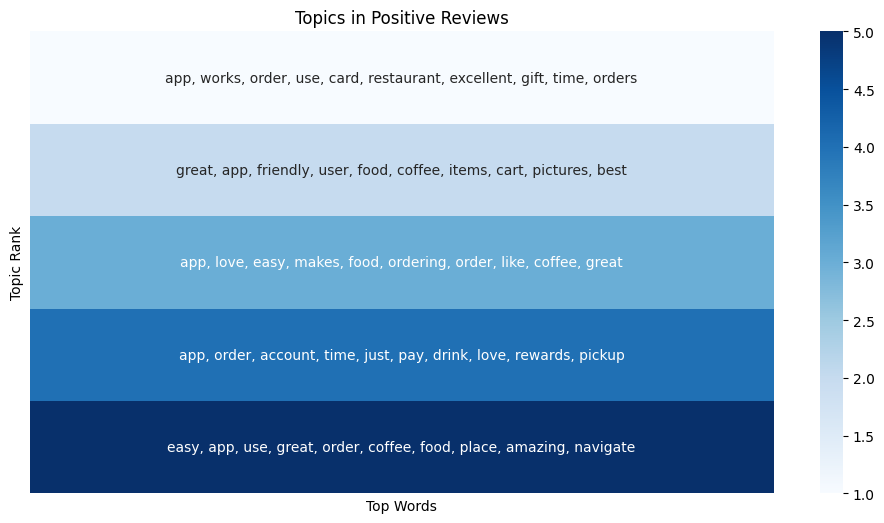

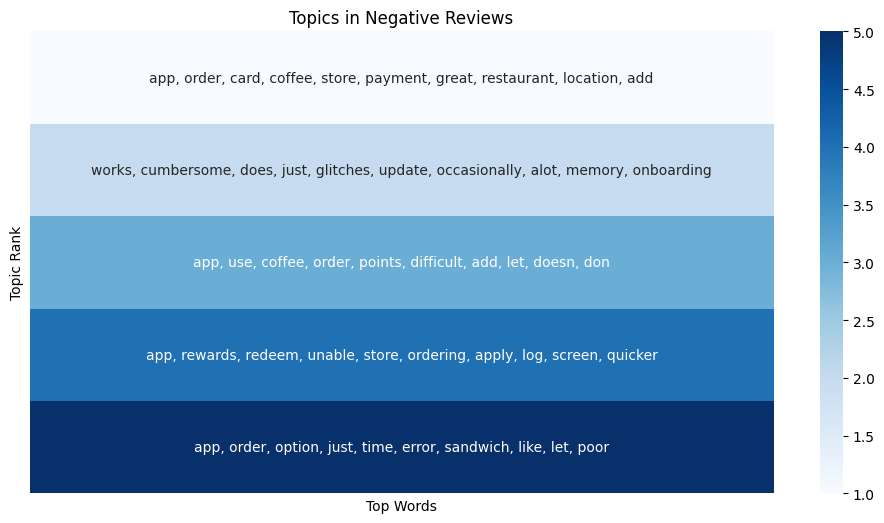

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def topic_modeling(corpus, n_topics=5):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(bag_of_words)
    return lda, vec

# Topic Modeling for Positive and Negative Reviews
lda_positive, vec_positive = topic_modeling(positive_corpus, n_topics=5)
lda_negative, vec_negative = topic_modeling(negative_corpus, n_topics=5)

def display_topics(model, feature_names, no_top_words, title):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_str = ', '.join(top_features)
        topics.append(topic_str)
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.array([range(1, len(topics)+1)]).T, annot=np.array(topics).reshape(-1, 1), fmt='', cmap='Blues')
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel('Top Words')
    plt.ylabel('Topic Rank')
    plt.show()

display_topics(lda_positive, vec_positive.get_feature_names_out(), 10, 'Topics in Positive Reviews')
display_topics(lda_negative, vec_negative.get_feature_names_out(), 10, 'Topics in Negative Reviews')

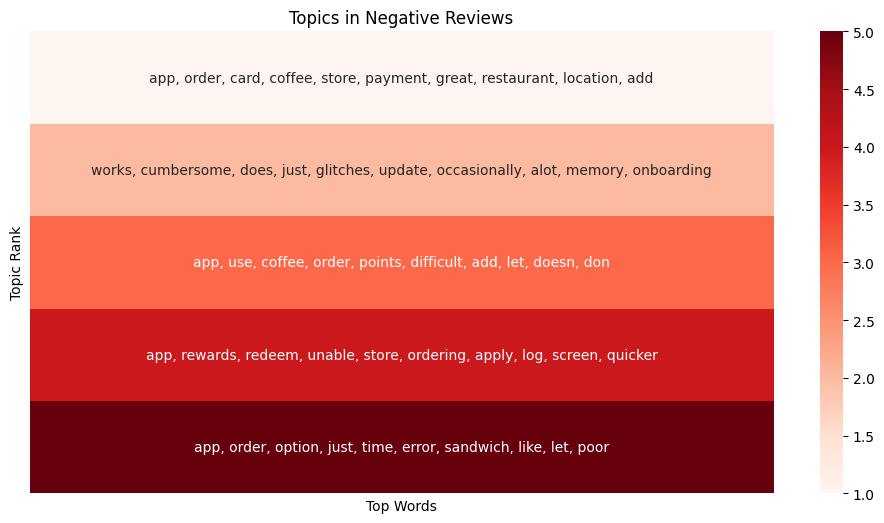

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def display_topics(model, feature_names, no_top_words, title):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_str = ', '.join(top_features)
        topics.append(topic_str)
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.array([range(1, len(topics)+1)]).T, annot=np.array(topics).reshape(-1, 1), fmt='', cmap='Reds')  # Changed colormap to 'Greens'
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel('Top Words')
    plt.ylabel('Topic Rank')
    plt.show()

display_topics(lda_negative, vec_negative.get_feature_names_out(), 10, 'Topics in Negative Reviews')